# Figure 1: generalisability & normative enrichments

## Setup

In [1]:
# Set working directory
%cd notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [6]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from triplets import *
from enrichments_data import *
from enrichments import *

### Compute components

First process AHBA data into a gene-by-region matrix and save to `/outputs`.

 `get_expression_abagen` is a wrapper around `abagen.get_expression_data` from the _abagen_ package that processes the AHBA with additional gene and region filters.
See: `code/processing.py`

In [41]:
# get_expression_abagen(fetch_hcp(), donors_threshold=0, gene_stability_threshold=0, save_name='hcp_base')
get_expression_abagen(fetch_hcp(), donors_threshold=3, gene_stability_threshold=0.5, lr_mirror = 'rightleft', save_name='hcp_3d_ds5')

INFO: Donor-specific atlases provided; using native coords for tissue samples
INFO: Reannotating probes with information from Arnatkevic̆iūtė et al., 2019, NeuroImage
INFO: Filtering probes with intensity-based threshold of 0.5
INFO: 32669 probes survive intensity-based filtering
INFO: Reducing probes indexing same gene with method: diff_stability
INFO: 15946 genes remain after probe filtering + selection
INFO: 458 / 477 samples matched to regions for donor #9861
INFO: 346 / 367 samples matched to regions for donor #10021
INFO: 173 / 181 samples matched to regions for donor #12876
INFO: 259 / 263 samples matched to regions for donor #14380
INFO: 222 / 224 samples matched to regions for donor #15496
INFO: 231 / 240 samples matched to regions for donor #15697
INFO: Aggregating samples to regions with provided region_agg: donors


137 / 180 regions remain after filtering for regions with samples from >= 3 donors
7973 / 15946 genes remain after filtering for top 0.5 stability
Expression matrix saved to ../data/abagen-data/expression/hcp_3d_ds5.csv


gene_symbol,A1BG,A1BG-AS1,AAAS,AAED1,AAGAB,AAK1,AARD,AARS,AASDH,AATF,...,ZSCAN31,ZSCAN5A,ZSCAN9,ZSWIM4,ZSWIM7,ZSWIM9,ZWINT,ZYX,ZZEF1,ZZZ3
label,,,,,,,,,,,,,,,,,,,,,
1,0.234124,0.260771,0.686152,0.279157,0.273262,0.670004,0.694569,0.500742,0.792507,0.286262,...,0.784252,0.220417,0.817429,0.793574,0.158462,0.183059,0.387873,0.839740,0.825577,0.346719
4,0.363618,0.284738,0.681523,0.376047,0.361952,0.713097,0.611765,0.558431,0.712702,0.438491,...,0.756393,0.321787,0.762999,0.703900,0.263233,0.207638,0.432438,0.810666,0.738654,0.357823
5,0.219162,0.217884,0.648171,0.253024,0.417117,0.693113,0.590371,0.509893,0.598864,0.308309,...,0.685411,0.184382,0.672967,0.815209,0.253009,0.366467,0.331184,0.784044,0.761205,0.309604
6,0.418642,0.400929,0.633253,0.344356,0.410166,0.626012,0.669849,0.472977,0.711426,0.485402,...,0.608851,0.326790,0.637188,0.590776,0.256030,0.469356,0.476248,0.684917,0.768377,0.443219
8,0.312791,0.376259,0.619065,0.434047,0.476786,0.630902,0.546099,0.648789,0.557849,0.734827,...,0.422620,0.658484,0.494481,0.566637,0.539222,0.380324,0.405083,0.716991,0.631567,0.326405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.490537,0.571867,0.409748,0.423437,0.549645,0.589994,0.586216,0.627218,0.517722,0.412377,...,0.583386,0.511735,0.505436,0.536468,0.667801,0.571593,0.502891,0.541865,0.565517,0.382571
176,0.690689,0.614500,0.441887,0.515177,0.479910,0.424057,0.490759,0.426175,0.437996,0.522981,...,0.451370,0.542929,0.375665,0.410888,0.480263,0.664362,0.554143,0.337370,0.439675,0.572576
177,0.691370,0.711700,0.493273,0.504368,0.479777,0.344129,0.450580,0.601366,0.507447,0.598878,...,0.526276,0.583738,0.340832,0.497315,0.549885,0.546639,0.561580,0.472524,0.369499,0.538924


Then find components: a base version using all data and PCA, and an optimised version using filtered data with DME.

`gradientVersion` is a wrapper around the `GradientMaps` class from the _BrainSpace_ package. See `code/gradientVersion.py`

In [8]:
pca_base = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


In [9]:
weights = dme_3d_ds5.weights.iloc[:,:3]
null_weights = shuffle_gene_weights(weights, n=5000, rank=False)

Output scores and weights

In [82]:
dme_3d_ds5.clean_scores().to_csv('../outputs/ahba_dme_hcp_top8kgenes_scores.csv')
dme_3d_ds5.weights.iloc[:,:3].to_csv('../outputs/ahba_dme_hcp_top8kgenes_weights.csv')

---

## Generalisability and brain maps of components

In [10]:
versions_scores = pd.concat({
   'PCA, all genes\nall regions': pca_base.clean_scores(),
   'DME, top 50% genes\nonly 3+ donor regions': dme_3d_ds5.clean_scores(),
}).reset_index(level=0).rename({'level_0': 'version'}, axis=1)

Triplets analysis requires re-processing AHBA for every permutation of data splits of the six brains. Uses functions in `code/triplets.py`. Run once and save to `/outputs`:

In [ ]:
# triplets_base = get_triplets(atlas=fetch_hcp(), donors_threshold=0)
# save_pickle(triplets_base, "triplets_base")

# triplets_3donors = get_triplets(atlas=fetch_hcp(), donors_threshold=3)
# save_pickle(triplets_3donors, "triplets_3donors")

For each triplets split, compute generalisability _g_ (i.e. absolute correlation of region scores) across different gene filter levels and save to `/outputs`.

In [11]:
# triplets_base = load_pickle('triplets')
# triplets_3donors = load_pickle('triplets_3donors')

# triplets_dict = {
#     'PCA, all regions': make_triplet_ds_plot(get_triplets_stability_levels(triplets_base)),
#     'DME, only 3+ donor regions': make_triplet_ds_plot(get_triplets_stability_levels(triplets_3donors))
# }
# save_pickle(triplets_dict, 'triplets_dict')

triplets_dict = load_pickle('triplets_dict')

Now we can present the results and plot panels **a** and **b**:

In [12]:
triplets_df = pd.concat({
    "PCA, all genes\nall regions": triplets_dict['PCA, all regions'].loc[lambda x: x['version']==0],
    "DME, top 50% genes\nonly 3+ donor regions": triplets_dict['DME, only 3+ donor regions'].loc[lambda x: x['version']==0.5]
}).drop('version', axis=1).reset_index(0).rename({'level_0':'version'}, axis=1)
# triplets_df

In [13]:
triplets_df.groupby(['version','how','component']).median()

corr  \
version                                   how           component             
DME, top 50% genes\nonly 3+ donor regions Region scores 1          0.956908   
                                                        2          0.666887   
                                                        3          0.643539   
                                                        4         -0.140626   
                                                        5         -0.010216   
PCA, all genes\nall regions               Region scores 1         -0.191852   
                                                        2          0.068152   
                                                        3          0.032535   
                                                        4         -0.112639   
                                                        5          0.033329   

                                                                   corr_abs  
version                                   how           component            
DME, top 50% genes\nonly 3+ donor regions Region scores 1          0.956908  
                                                        2          0.723390  
                                                        3          0.643539  
                                                        4          0.279726  
                                                        5          0.330640  
PCA, all genes\nall regions               Region scores 1          0.721299  
                                                        2          0.118019  
                                                        3          0.112725  
                                                        4          0.145198  
                                                        5          0.298827

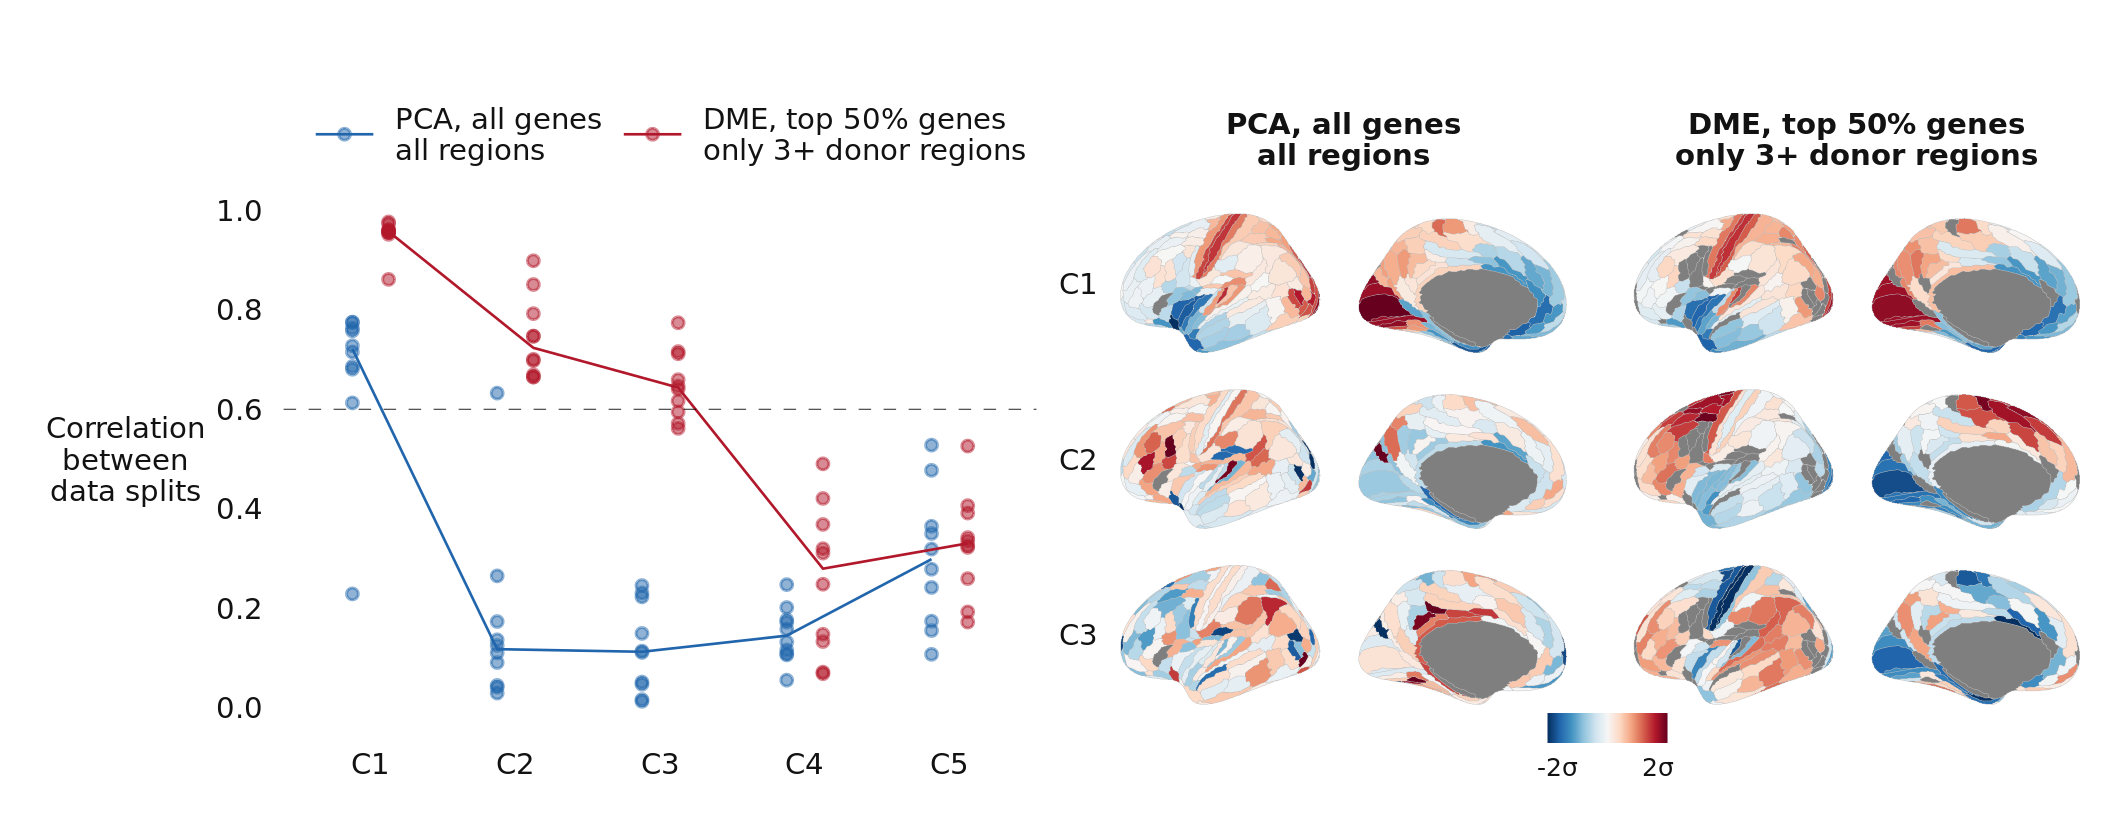

In [34]:
%%R -i triplets_df -i versions_scores -w 180 -h 70 --units mm -r 300
source("../code/fig1_plots.R")

c1 <- plot_generalisability(triplets_df) + 
        # scale_color_manual(values=c(brewer.rdbu(10)[c(9)], 'white')) +
        ylab('Correlation\nbetween\ndata splits')
c2 <- plot_brain_maps(versions_scores)

(c1 + c2 + plot_layout(widths=c(1.5,2)) )

---

## Normative enrichments

Use code from `code/enrichments_data.py` and `code/enrichments.py` to compute normative enrichments for: **c** Gene Ontology (GO) Biological Processes, **d** cortical layers, **e** cell types, **f** educational attainment GWAS, and **g** intelligence GWAS.

### GO enrichments

GO BP_enrichments are computed externally in _STRING_ online software. (Results when computed directly are similar)

In [15]:
go_enrichments = combine_go_enrichments('dm_hcp_3d_ds5', 'Process', include_c1=True, top_n=1000, FDR_filter=0.05)

In [16]:
pd.options.display.max_rows=20
# go_enrichments.loc[lambda x: x['C']=='C2'].loc[lambda x: x['direction']=='top'].sort_values(['direction', 'FDR']).reset_index(drop=True)
go_enrichments.loc[lambda x: x['C']=='C3'].loc[lambda x: x['direction']=='bottom'].sort_values(['direction', 'FDR']).reset_index(drop=True)


,C,direction,description,n_genes,enrichment,FDR,neglogFDR,FDR_rank,enrichment_rank,rank,maxrank
0,C3,bottom,Regulation of synaptic plasticity,117,1.741190,0.00029,3.537602,1.0,11.0,27.0,27.0
1,C3,bottom,Serotonin receptor signaling,16,3.447860,0.00470,2.327902,2.0,4.0,26.0,27.0
2,C3,bottom,Regulation of circadian rhythm,56,1.685780,0.00660,2.180456,3.0,12.0,25.0,27.0
3,C3,bottom,Dendrite development,82,1.469090,0.00660,2.180456,4.0,19.0,24.0,27.0
4,C3,bottom,Dendritic spine development,44,2.050480,0.01120,1.950782,5.0,9.0,23.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...
22,C3,bottom,Neurotransmitter transport,77,1.582640,0.03980,1.400117,23.0,16.0,5.0,27.0
23,C3,bottom,Cognition,161,0.987496,0.04010,1.396856,24.0,26.0,4.0,27.0
24,C3,bottom,Regulation of neurotransmitter receptor activity,50,1.509860,0.04360,1.360514,25.0,18.0,3.0,27.0
25,C3,bottom,Vocalization behavior,10,3.349370,0.04480,1.348722,26.0,5.0,2.0,27.0


In [497]:
# go_enrichments.to_csv("../outputs/ahba_GO_enrichments.csv")

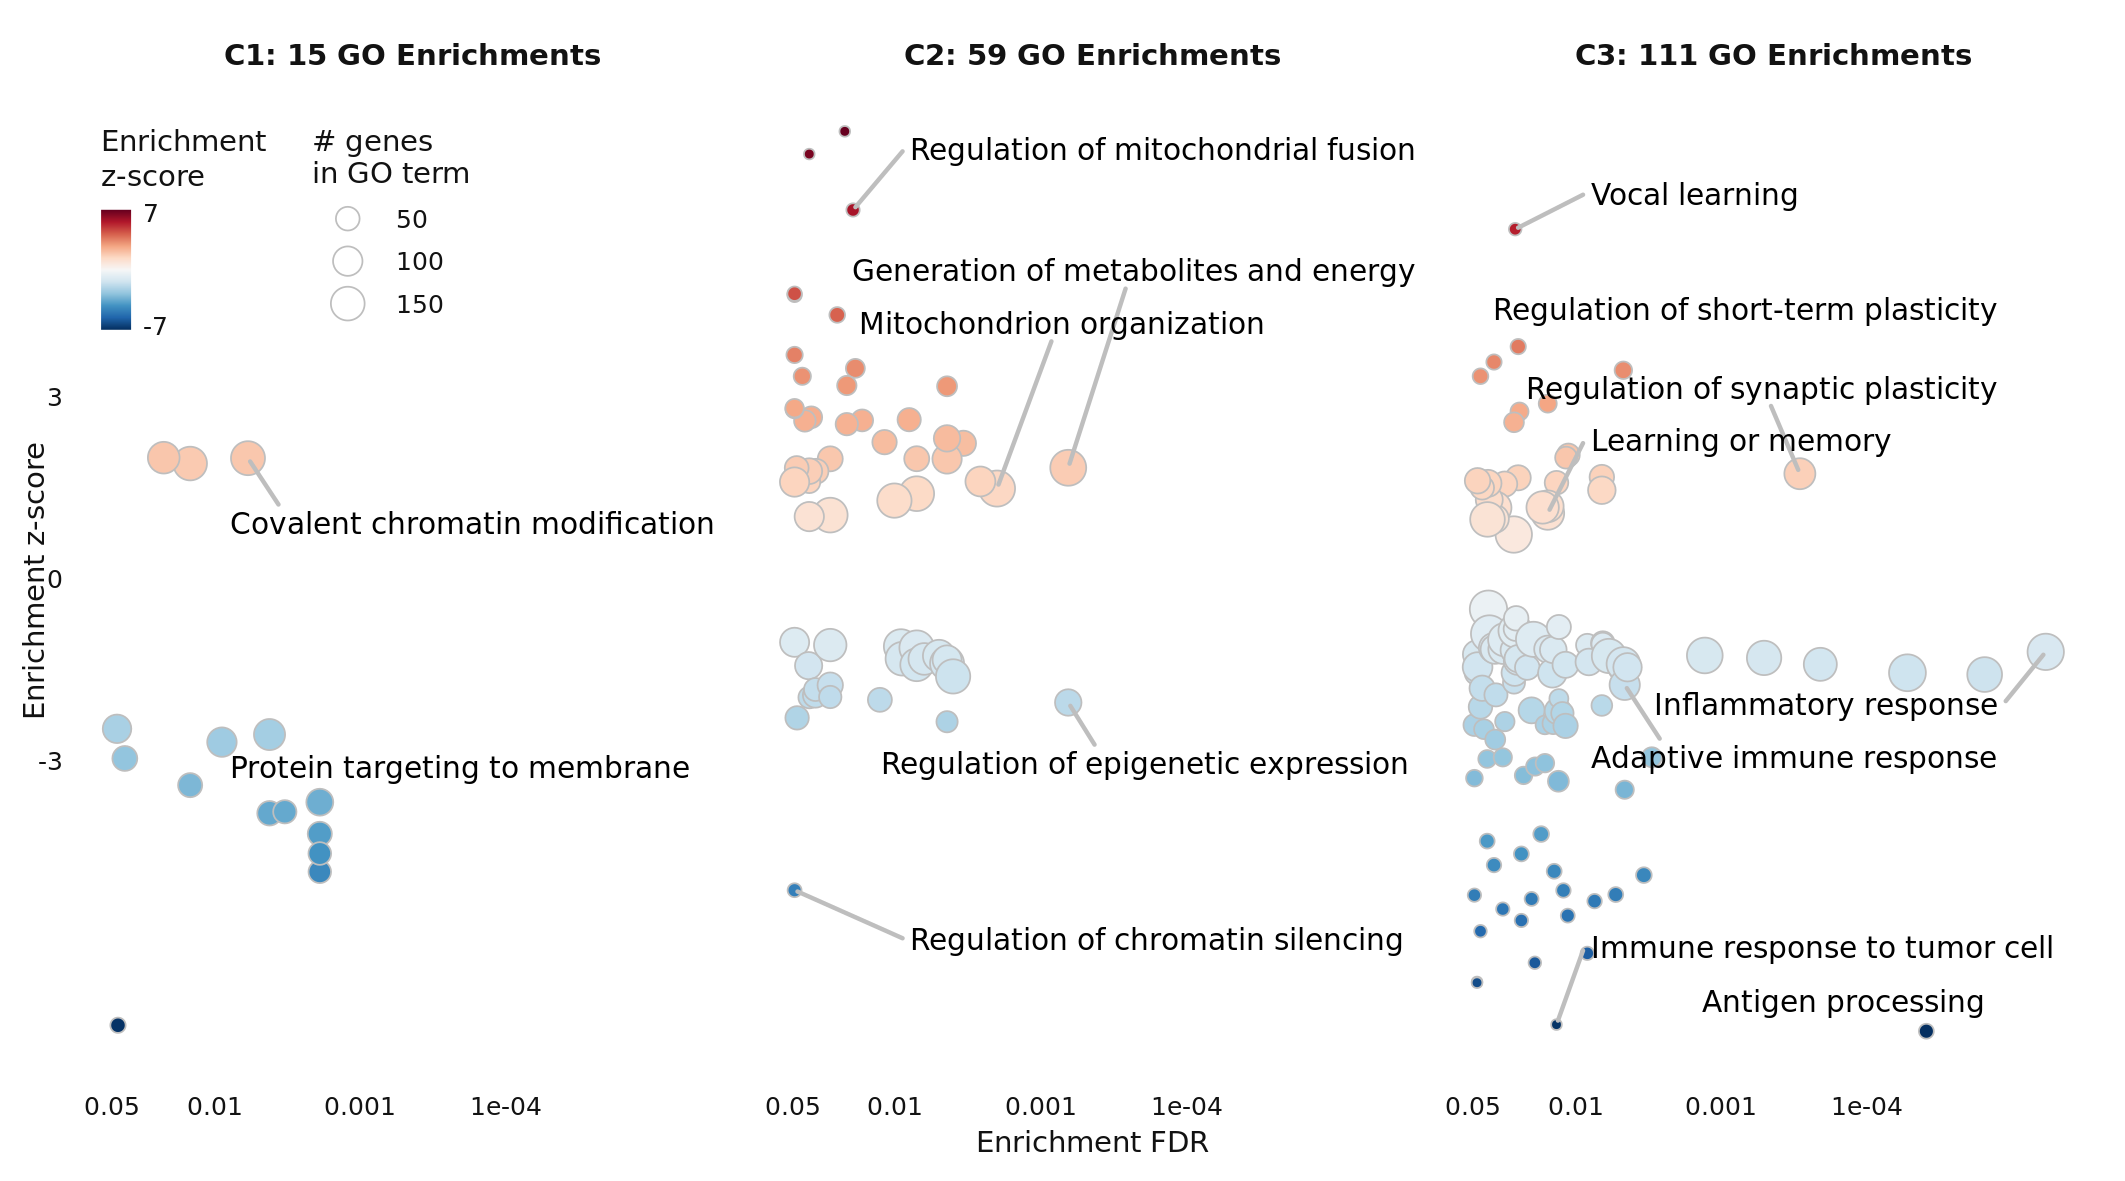

In [18]:
%%R -i go_enrichments -w 180 -h 100 -u mm -r 300
source("../code/fig1_plots.R")
plot_go_enrichments(go_enrichments)

### Layer enrichments

In [19]:
layer_genes = get_layer_genes(which='maynard', add_hse_genes=False)
layer_stats = compute_null_p(*compute_enrichments(weights, null_weights, layer_genes))

### Cell enrichments

In [20]:
cell_genes = get_cell_genes(which='seidlitz', add_synapses=True)
order = ['Synapses', 'Neuro-Ex', 'Neuro-In', 'Astro', 'Micro', 'Endo', 'Oligo', 'OPC']
true_scores, null_scores, counts = compute_enrichments(weights, null_weights, cell_genes, how='mean')
cell_stats = compute_null_p(true_scores, null_scores, adjust='fdr_bh', order=order)

In [21]:
cell_rename = {
    'Synapses':'Syn',
    'Neuro-Ex':'N-Ex',
    'Neuro-In':'N-In',
    'Astro':'Astro',
    'Micro':'Micro',
    'Endo':'Endo',
    'Oligo':'Oligo',
    'OPC':'OPC'
}
# cell_rename = {v:k for k,v in cell_rename.items()}
    
cell_stats = cell_stats.replace({'label':cell_rename}).sort_values(['label','C'])


### GWAS enrichments

In [22]:
gwas_intelligence = get_intelligence_gwas_genes()
order = ['Davies 2018','Savage 2018','Hill 2019','Hatoum 2022']
gwas_intelligence_stats = compute_null_p(*compute_enrichments(weights, null_weights, gwas_intelligence), order=order)
gwas_intelligence_stats

,label,C,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
3,Davies 2018,C1,0.9436,0.020227,-0.032931,0.033942,1.566183,True,0.1128,0.135360,False,709,289
4,Davies 2018,C2,0.0060,-0.018002,0.026822,0.018272,-2.453151,False,0.0120,0.024000,True,709,289
5,Davies 2018,C3,0.9986,0.052348,0.006644,0.014921,3.063064,True,0.0028,0.009600,True,709,289
6,Savage 2018,C1,0.9360,0.013263,-0.032450,0.029764,1.535842,True,0.1280,0.139636,False,859,371
7,Savage 2018,C2,0.0384,-0.001729,0.027093,0.016136,-1.786203,False,0.0768,0.102400,False,859,371
8,Savage 2018,C3,0.9996,0.054908,0.006770,0.013073,3.682387,True,0.0008,0.004800,True,859,371
0,Hill 2019,C1,0.8860,0.014433,-0.032121,0.038167,1.219757,True,0.2280,0.228000,False,538,237
1,Hill 2019,C2,0.0016,-0.032523,0.026931,0.020074,-2.961688,False,0.0032,0.009600,True,538,237
2,Hill 2019,C3,0.9922,0.045970,0.006900,0.016131,2.421982,True,0.0156,0.026743,True,538,237
9,Hatoum 2022,C1,0.9846,0.048403,-0.033176,0.037474,2.176933,True,0.0308,0.046200,True,507,236


In [23]:
gwas_education = (pd.read_csv("../data/gwas/lee2018_tableS7.csv", header=1, usecols=['Gene symbol'])
               .dropna().rename({'Gene symbol':'gene'}, axis=1).assign(label='Lee 2018'))
gwas_education_stats = compute_null_p(*compute_enrichments(weights, null_weights, gwas_education))
gwas_education_stats

,label,C,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,Lee 2018,C1,0.9844,-0.005247,-0.032588,0.012745,2.145184,True,0.0312,0.0312,True,4439,1690
1,Lee 2018,C2,0.0050,0.009469,0.026720,0.006819,-2.529803,False,0.0100,0.0150,True,4439,1690
2,Lee 2018,C3,0.9998,0.025588,0.006761,0.005519,3.411457,True,0.0004,0.0012,True,4439,1690


### Enrichments subpanel

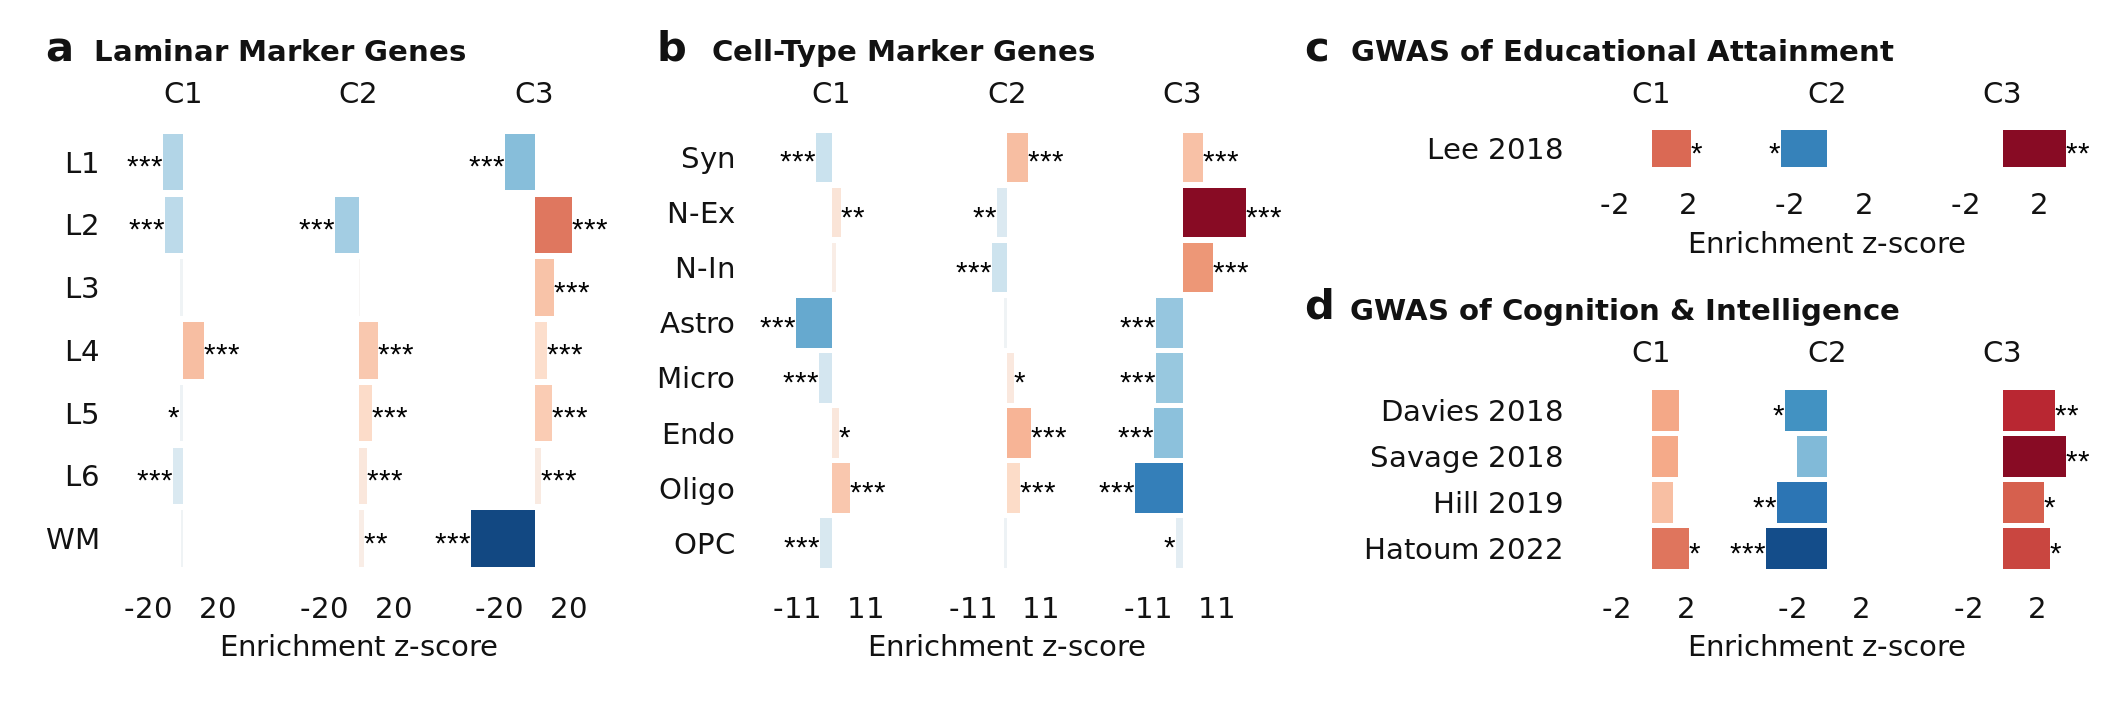

In [24]:
%%R -i cell_stats -i layer_stats -i gwas_intelligence_stats -i gwas_education_stats -w 180 -h 60 --units mm -r 300
source("../code/fig1_plots.R")

g_layers <- plot_enrichment_bars_z(layer_stats) + 
        ggtitle('Laminar Marker Genes') +
        theme(
                axis.text.y = element_text(margin=margin(r=-1, 'mm')),
                plot.title.position = "plot",
                plot.title = element_text(hjust=0.25, vjust=0, margin = margin(t=-1,r=0,b=0,l=0,'mm')),
        )

g_cells <- plot_enrichment_bars_z(cell_stats) + 
        ggtitle('Cell-Type Marker Genes') +
        theme(
                plot.title.position = "plot",
                plot.title = element_text(hjust=0.25, vjust=0, margin = margin(t=-1,r=0,b=0,l=0,'mm')),
        )

g_gwas_intelligence <- plot_enrichment_bars_z(gwas_intelligence_stats) +
        ggtitle('GWAS of Cognition & Intelligence') +
        theme(
                axis.text.y = element_text(margin=margin(t=0,r=0,b=0,l=5,'mm')),
                plot.title = element_text(hjust=0.2, vjust=0, margin = margin(t=-1,r=0,b=0,l=0,'mm')),
                plot.title.position = "plot",
                plot.tag.position = c(0,1)
        )

g_gwas_education <- plot_enrichment_bars_z(gwas_education_stats) +
        ggtitle('GWAS of Educational Attainment') +
        theme(
                axis.text.y = element_text(margin=margin(t=0,r=0,b=0,l=1,'mm')),
                plot.title = element_text(hjust=0.2, vjust=0, margin = margin(t=-1,r=0,b=0,l=0,'mm')),
                plot.title.position = "plot",
                plot.tag.position = c(0,1)
        )

design = c(
    area(t=1, b=20, l=1, r=16),
    area(t=1, b=20, l=17, r=32),
    area(t=1, b=4, l=33, r=48),
    area(t=5, b=20, l=33, r=48)
)

enrichments_panels <- (g_layers + g_cells + g_gwas_education + g_gwas_intelligence) + 
                        plot_layout(design=design) + plot_annotation(tag_level='a')
enrichments_panels

## Combined figure 1

Use `patchwork` package to combine into single figure

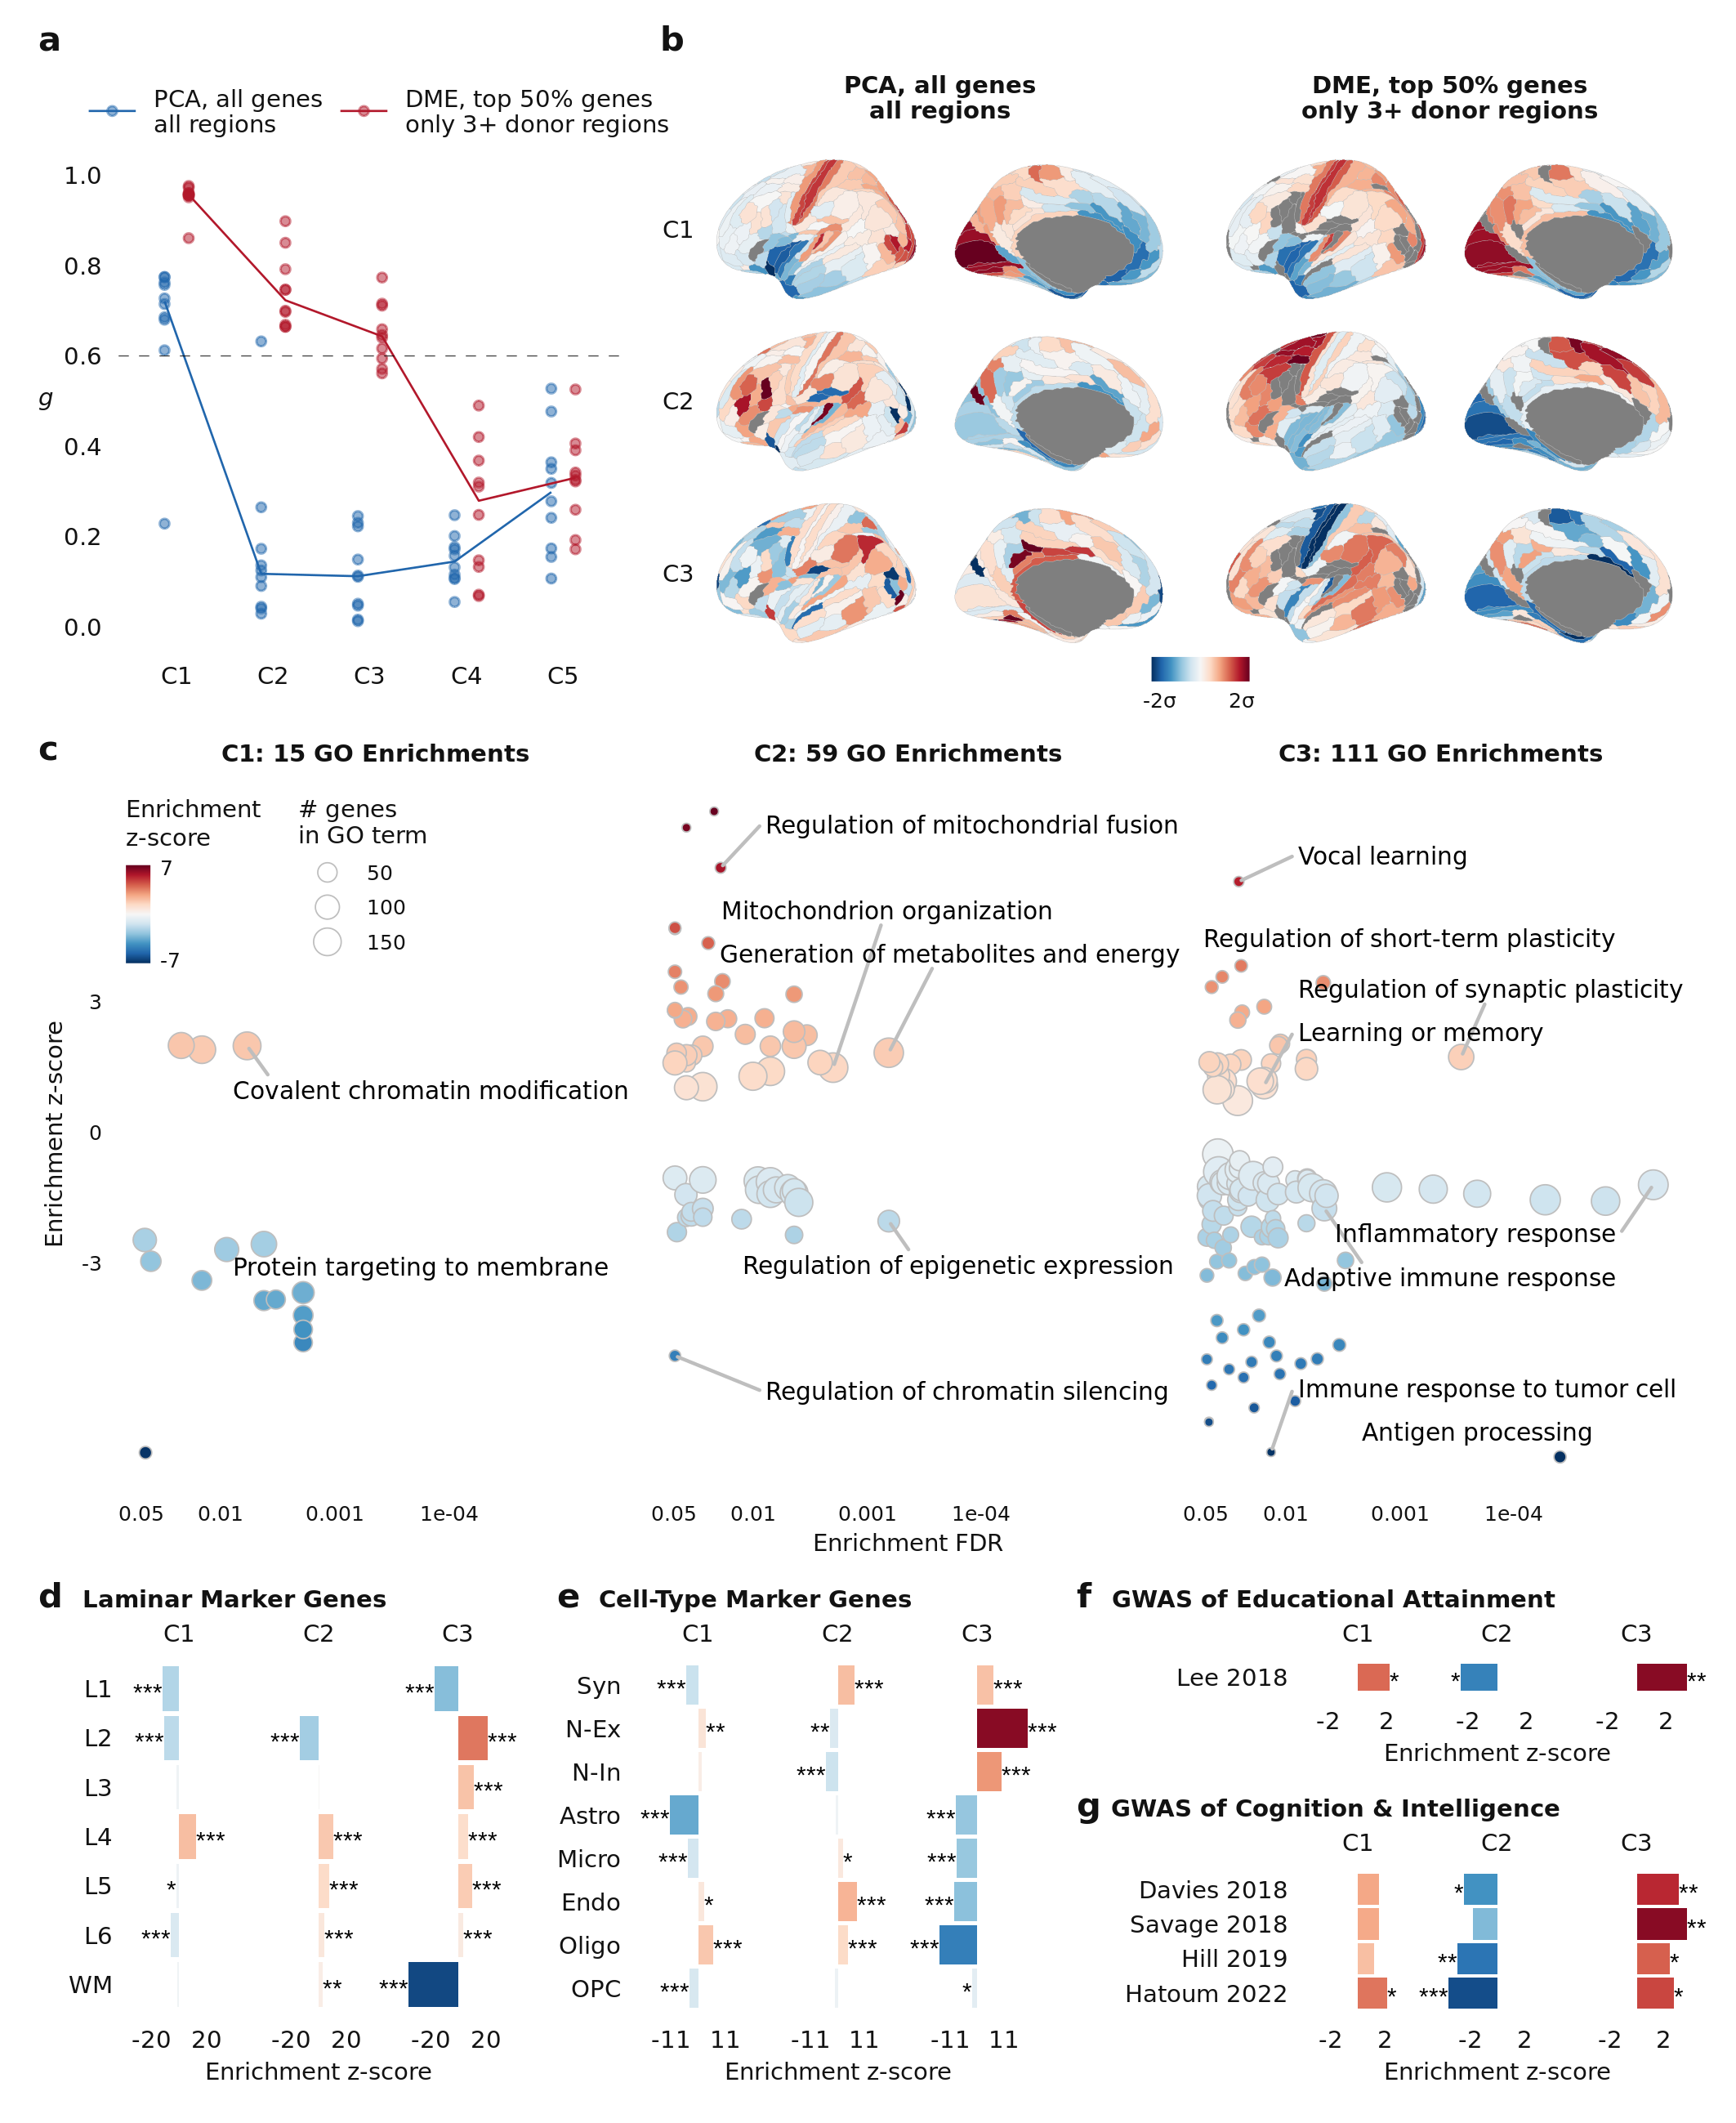

In [39]:
%%R -i triplets_df -i versions_scores -i go_enrichments -w 180 -h 220 --units mm -r 300
source("../code/fig1_plots.R")

p1 <- plot_generalisability(triplets_df) 
p2 <- plot_brain_maps(versions_scores)
p3 <- plot_go_enrichments(go_enrichments) + theme(plot.tag.position = c(0,.975))

layout <- c(
  area(t = 1, b = 70, l = 1, r = 60),
  area(t = 1, b = 70, l = 61, r = 180),
  area(t = 71, b = 170, l = 1, r = 180),
  area(t = 171, b = 220, l = 1, r = 180)
)

plot <- p1 + p2 + p3 + enrichments_panels + plot_layout(design=layout)

themed <- plot & theme(plot.margin = margin(t=2, b=2, l=2, r=2, unit='mm'))

annotated <- themed + plot_annotation(tag_level='a')
annotated

In [40]:
%%R
ggsave(file="../outputs/figures/fig1.svg", plot=annotated, width=180, height=220, units='mm')

## Other results related to Fig 1

### Burt PC1

In [870]:
burt_pc1 = nib.load("../data/burt_brain_pc1.pscalar.nii").get_fdata()
burt_pc1 = pd.Series(burt_pc1.squeeze(), index=range(1,181), name='Burt_PC1')

In [871]:
scores.join(burt_pc1).corr()

,C1,C2,C3,Burt_PC1
C1,1.000000e+00,5.450628e-07,-6.239683e-07,0.960411
C2,5.450628e-07,1.000000e+00,-6.237271e-07,-0.016629
C3,-6.239683e-07,-6.237271e-07,1.000000e+00,-0.007721
Burt_PC1,9.604106e-01,-1.662941e-02,-7.720735e-03,1.000000


### Cross-correlation

In [162]:
# Scores
dme_3d_ds5.clean_scores().corr()

,C1,C2,C3
C1,1.000000e+00,2.687598e-08,5.443088e-08
C2,2.687598e-08,1.000000e+00,6.623748e-08
C3,5.443088e-08,6.623748e-08,1.000000e+00


In [164]:
# Weights
dme_3d_ds5.weights.corr()

,C1,C2,C3
C1,1.000000,-0.040324,-0.018672
C2,-0.040324,1.000000,-0.106929
C3,-0.018672,-0.106929,1.000000


### Smoothness (Moran's I)

In [165]:
versions_scores.iloc[:,:4].groupby('version', sort=False).agg(get_moran_I).T

version,"PCA, all genes\nall regions","DME, top 50% genes\nonly 3+ donor regions"
C1,0.485524,0.484978
C2,0.090060,0.584921
C3,0.067315,0.205841


### Variance explained

PCA var explained

In [486]:
pca_3d_ds5 = gradientVersion(approach='pca').fit('hcp_3d_ds5')
pca_3d_ds5.eigenvalues / pca_3d_ds5.expression.var().sum()

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_3d_ds5


array([0.38643026, 0.10670729, 0.07439592, 0.05532164, 0.03492906])

In [492]:
pca_3d_ds5.corr_scores(dme_3d_ds5)

,0,1,2,3,4
0,0.995508,-0.011770,-0.006964,-0.031811,0.015165
1,0.011112,0.972872,-0.186103,-0.037033,-0.002613
2,0.000571,0.136487,0.878593,-0.196713,0.314559
3,0.015844,0.082656,0.151352,0.906994,0.234354
4,0.016888,-0.011703,0.166416,0.196086,-0.742314


Var explained from regressing out components

In [493]:
get_var_explained(dme_3d_ds5)

array([0.38304296, 0.10311451, 0.06534923])

In [488]:
get_var_explained(pca_3d_ds5)

array([0.38304296, 0.10311451, 0.06534923])

### How many correlated genes

In [166]:
top100 = dme_3d_ds5.weights.abs().rank(ascending=False) < 100
np.nanmean(np.where(top100, dme_3d_ds5.weights.abs(), np.NaN), 0)

array([0.93867909, 0.76972631, 0.6772911 ])

In [171]:
(dme_3d_ds5.weights.abs() > 0.5).sum()

C1    4867
C2     967
C3     437
dtype: int64

In [168]:
(dme_3d_ds5.weights.abs() > 0.5).sum() / len(dme_3d_ds5.weights)

C1    0.610435
C2    0.121284
C3    0.054810
dtype: float64

### XYZ corrs

In [181]:
def get_xyz_corrs(version):
    hcp_xyz = fetch_hcp()['info'].loc[:180,['id','x-cog','y-cog','z-cog']].set_index('id').set_axis(['x','y','z'],axis=1)
    return version.clean_scores().join(hcp_xyz).corr().iloc[3:,:3]

get_xyz_corrs(dme_3d_ds5)

,C1,C2,C3
x,0.031332,-0.075160,0.384444
y,-0.636631,0.496127,-0.028524
z,0.535597,0.580218,-0.159710


In [182]:
get_xyz_corrs(dme_3d_ds5).corr()

,C1,C2,C3
C1,1.000000,0.037724,-0.152041
C2,0.037724,1.000000,-0.993406
C3,-0.152041,-0.993406,1.000000
